In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import to_scipy_sparse_matrix
from torch_geometric.data import Data
from scipy.sparse import csr_matrix, coo_matrix
import numpy as np
import time
from torch.nn import Linear, Parameter
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree

In [ ]:
class GCNConv(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super().__init__(aggr='add')  # "Add" aggregation (Step 5).
        self.lin = Linear(in_channels, out_channels, bias=False)
        self.bias = Parameter(torch.empty(out_channels))
        self.reset_parameters()

    def reset_parameters(self):
        self.lin.reset_parameters()
        self.bias.data.zero_()

    def forward(self, x, edge_index):
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))
        x = self.lin(x)
        row, col = edge_index
        deg = degree(col, x.size(0), dtype=x.dtype)
        deg_inv_sqrt = deg.pow(-0.5)
        deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]
        out = self.propagate(edge_index, x=x, norm=norm)
        out = out + self.bias
        return out

    def message(self, x_j, norm):
        return norm.view(-1, 1) * x_j

In [ ]:
class GCN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_size, hidden_size)
        self.conv2 = GCNConv(hidden_size, output_size)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        return x

In [ ]:
def measure_time(func, *args, **kwargs):
    start = time.time()
    func(*args, **kwargs)
    end = time.time()
    return end - start

In [ ]:
def train_epoch(model, data, optimizer, criterion, device, num_epochs):
    model.train()
    data = data.to(device)
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()

def inference(model, data, num_iterations, device):
    model.eval()
    data = data.to(device)
    for _ in range(num_iterations):
        with torch.no_grad():
            out = model(data.x, data.edge_index)

In [ ]:
dataset = Planetoid(root='data/Planetoid', name='Cora')
data = dataset[0]

input_size = dataset.num_features
hidden_size = 16
output_size = dataset.num_classes
num_epochs = 100
num_iterations = 500

In [ ]:
# Konwersja do macierzy sąsiedztwa COO
adj_coo = to_scipy_sparse_matrix(data.edge_index).tocoo()

# Konwersja macierzy sąsiedztwa do tensora edge_index
edge_index_coo = torch.tensor([adj_coo.row, adj_coo.col], dtype=torch.long)

# Tworzenie obiektu danych Data dla COO
data_coo = Data(x=data.x, edge_index=edge_index_coo, y=data.y)

In [ ]:
# Konwersja do macierzy sąsiedztwa CSR
adj_csr = csr_matrix((np.ones(adj_coo.nnz), (adj_coo.row, adj_coo.col)), shape=adj_coo.shape)

# Tworzenie obiektu danych Data dla CSR
edge_index_csr = torch.tensor(adj_csr.nonzero(), dtype=torch.long)
data_csr = Data(x=data.x, edge_index=edge_index_csr, y=data.y)

In [ ]:
device_cpu = torch.device('cpu')
device_gpu = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
model_coo = GCN(input_size, hidden_size, output_size).to(device_cpu)
model_csr = GCN(input_size, hidden_size, output_size).to(device_cpu)
optimizer_coo = optim.Adam(model_coo.parameters(), lr=0.01)
optimizer_csr = optim.Adam(model_csr.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

In [ ]:
time_coo_cpu_train = measure_time(train_epoch, model_coo, data_coo, optimizer_coo, criterion, device_cpu, num_epochs)
time_coo_cpu_infer = measure_time(inference, model_coo, data_coo, num_iterations, device_cpu)

time_csr_cpu_train = measure_time(train_epoch, model_csr, data_csr, optimizer_csr, criterion, device_cpu, num_epochs)
time_csr_cpu_infer = measure_time(inference, model_csr, data_csr, num_iterations, device_cpu)

In [8]:
print("COO CPU Train Time: {:.4f} seconds".format(time_coo_cpu_train))
print("COO CPU Inference Time: {:.4f} seconds".format(time_coo_cpu_infer))
print("CSR CPU Train Time: {:.4f} seconds".format(time_csr_cpu_train))
print("CSR CPU Inference Time: {:.4f} seconds".format(time_csr_cpu_infer))

COO CPU Train Time: 1.6544 seconds
COO CPU Inference Time: 2.6101 seconds
CSR CPU Train Time: 1.5693 seconds
CSR CPU Inference Time: 3.7772 seconds


In [9]:
import matplotlib.pyplot as plt
import random
import pandas as pd
import seaborn.objects as so

In [10]:
data = [{'type': 'Train', 'matrix_type': 'CSR', 'time[s]': time_csr_cpu_train}, #training_time in minutes
        {'type': 'Train', 'matrix_type': 'COO', 'time[s]': time_coo_cpu_train},
        {'type': 'Inference', 'matrix_type': 'CSR', 'time[s]': time_csr_cpu_infer},
        {'type': 'Inference', 'matrix_type': 'COO', 'time[s]': time_coo_cpu_infer},]
 
df = pd.DataFrame(data)
 
print(df)

        type matrix_type   time[s]
0      Train         CSR  1.569256
1      Train         COO  1.654390
2  Inference         CSR  3.777249
3  Inference         COO  2.610090


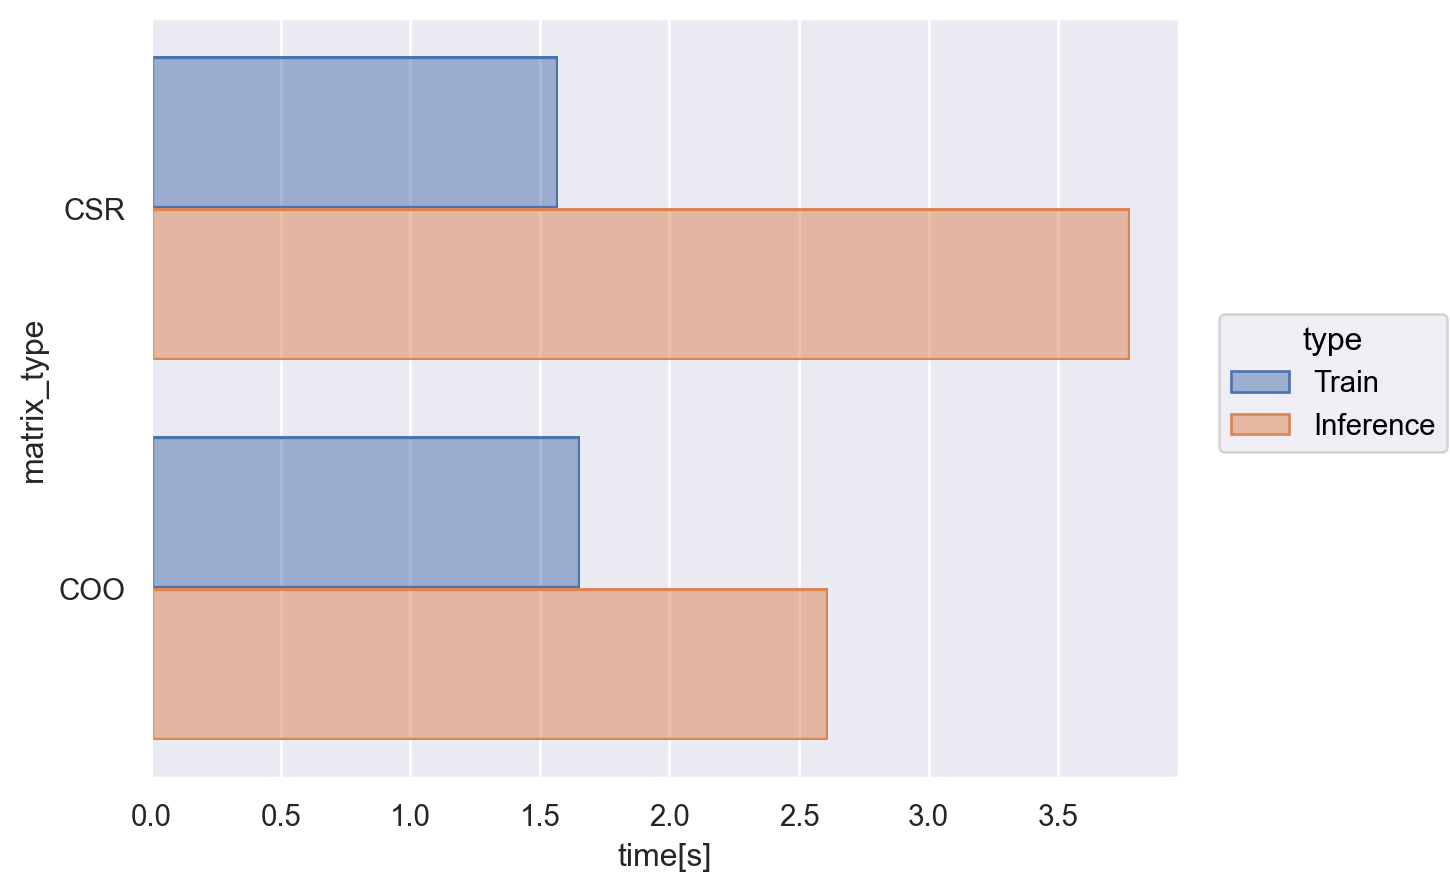

In [11]:
p = (so.Plot(df, "time[s]", "matrix_type", color="type")
.add(so.Bar(alpha=.5), so.Agg(), so.Dodge()))
p.label(title="Training Time with respect to Sparse Matrix Format")
p.save("training_time.png")